# CfRadial1

### Imports

In [1]:
import os
import tempfile
import cmweather
import numpy as np
import xarray as xr
import xradar as xd
import datatree as xt
from open_radar_data import DATASETS

### Download

Fetching CfRadial1 radar data file from [open-radar-data](https://github.com/openradar/open-radar-data) repository.

In [2]:
filename = DATASETS.fetch("cfrad.20080604_002217_000_SPOL_v36_SUR.nc")

In [3]:
radar = xd.io.open_cfradial1_datatree(filename, first_dim="auto")
display(radar)

DataTree('root', parent=None)
│   Dimensions:              (sweep: 9)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int32 ...
│       platform_type        |S32 ...
│       primary_axis         |S32 ...
│       status_str           |S1 ...
│       instrument_type      |S32 ...
│       time_coverage_start  |S32 ...
│       time_coverage_end    |S32 ...
│       latitude             float64 ...
│       longitude            float64 ...
│       altitude             float64 ...
│       sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_7' 'sweep_8'
│       sweep_fixed_angle    (sweep) float32 ...
│   Attributes: (12/13)
│       Conventions:         CF/Radial instrument_parameters radar_parameters rad...
│       version:             1.2
│       title:               TIMREX
│       institution:         
│       references:          
│       source:              
│       ...                  ...
│       comment:             
│       instrument_name:     SPOLRVP8
│       site_name:           
│       scan_name:           
│       scan_id:             0
│       platform_is_mobile:  false
├── DataTree('radar_parameters')
│       Dimensions:                   ()
│       Data variables:
│           radar_receiver_bandwidth  float32 ...
│           radar_beam_width_v        float32 ...
│           radar_antenna_gain_v      float32 ...
│           radar_antenna_gain_h      float32 ...
│           radar_beam_width_h        float32 ...
├── DataTree('radar_calibration')
│       Dimensions:                   ()
│       Data variables: (12/45)
│           time                      |S32 ...
│           pulse_width               timedelta64[ns] ...
│           xmit_power_h              float32 ...
│           xmit_power_v              float32 ...
│           two_way_waveguide_loss_h  float32 ...
│           two_way_waveguide_loss_v  float32 ...
│           ...                        ...
│           test_power_h              float32 ...
│           test_power_v              float32 ...
│           receiver_slope_hc         float32 ...
│           receiver_slope_vc         float32 ...
│           receiver_slope_hx         float32 ...
│           receiver_slope_vx         float32 ...
├── DataTree('georeferencing_correction')
│       Dimensions:                            ()
│       Data variables: (12/16)
│           latitude_correction                float32 ...
│           tilt_correction                    float32 ...
│           longitude_correction               float32 ...
│           radar_altitude_correction          float32 ...
│           roll_correction                    float32 ...
│           heading_correction                 float32 ...
│           ...                                 ...
│           vertical_velocity_correction       float32 ...
│           eastward_ground_speed_correction   float32 ...
│           pitch_correction                   float32 ...
│           drift_correction                   float32 ...
│           northward_ground_speed_correction  float32 ...
│           azimuth_correction                 float32 ...
├── DataTree('sweep_0')
│       Dimensions:                    (azimuth: 483, range: 996)
│       Coordinates:
│           time                       (azimuth) datetime64[ns] 2008-06-04T00:15:34 ....
│         * range                      (range) float32 150.0 300.0 ... 1.494e+05
│         * azimuth                    (azimuth) float32 0.0 0.75 1.5 ... 358.5 359.2
│           elevation                  (azimuth) float32 ...
│           latitude                   float64 ...
│           longitude                  float64 ...
│           altitude                   float64 ...
│       Data variables: (12/18)
│           sweep_number               int32 ...
│           sweep_mode                 |S32 ...
│           prt_mode                   |S32 ...
│           follow_mode                |S32 ...
│           sweep_fixed_angle          float32 ...
│     

### Plot Azimuth vs. Range

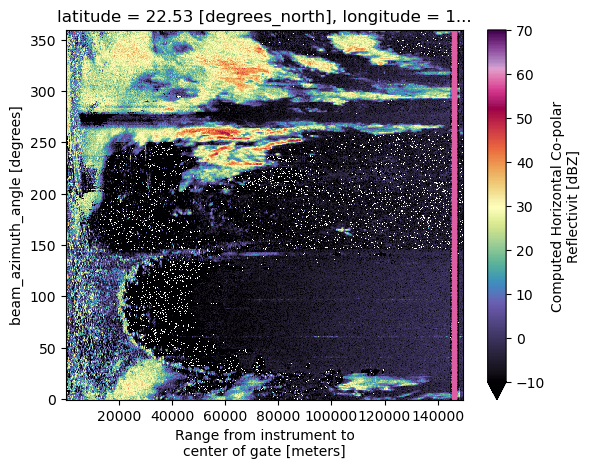

In [5]:
radar.sweep_0.DBZ.plot(cmap="ChaseSpectral", vmin=-10, vmax=70)

### Plot Time vs. Range

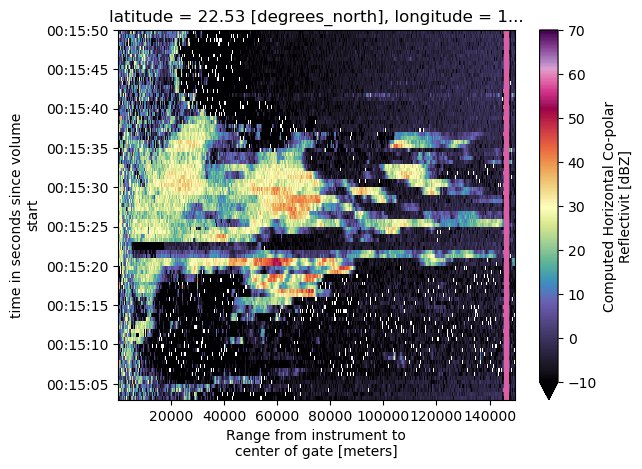

In [8]:
radar.sweep_0.DBZ.swap_dims({'azimuth':'time'}).sortby('time').plot(cmap="ChaseSpectral", vmin=-10, vmax=70)

### Georeference

In [ ]:
radar = radar.xradar.georeference()
display(radar)

### Plot PPI

In [ ]:
radar["sweep_0"]["DBZ"].plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=70)

### Filter

Apply basic reflectivity filter. This is just a demonstration.

In [ ]:
def ref_filter(dtree, sweep="sweep_0", field="DBZ"):
    ds = dtree[sweep].where((dtree[sweep][field] >= -10) & (dtree[sweep][field] <= 70))
    red_patch = ds.where(
        (
            (ds[field] >= ds[field].max().values - 0.5)
            & (ds[field] <= ds[field].max().values + 0.5)
        ),
        drop=True,
    )
    rmin, rmax = int(red_patch.range.min().values - 150), int(
        red_patch.range.max().values + 150
    )
    out_of_range_mask = (ds.range < rmin) | (ds.range > rmax)
    ds[field] = ds[field].where(out_of_range_mask)
    # Interpolate missing values using the slinear method along the 'range' dimension
    ds[field] = ds[field].interpolate_na(dim="range", method="slinear")
    dtree[sweep][f"corr_{field}"] = ds[field].copy()
    return dtree[sweep]

In [ ]:
swp0 = ref_filter(radar, sweep="sweep_0", field="DBZ")

In [ ]:
swp0.corr_DBZ.plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=70)

### Filter full volume

In [ ]:
# Initialize an empty DataTree
result_tree = xt.DataTree()

for sweep in radar.sweep_group_name.values:
    corrected_data = ref_filter(radar, sweep, field="DBZ")

    # Convert the xarray Dataset to a DataTree and add it to the result_tree
    data_tree = xt.DataTree.from_dict(corrected_data.to_dict())

    # Copy the contents of data_tree into result_tree
    for key, value in data_tree.items():
        result_tree[key] = value

In [ ]:
radar.sweep_6.corr_DBZ.plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=70)

### Export

Export to CfRadial1

In [ ]:
xd.io.to_cfradial1(dtree=radar, filename="cfradial1_qced.nc", calibs=True)

In [ ]:
?xd.io.to_cfradial1

### Note 

If `filename` is `None` in the `xd.io.to_cfradial1` function, it will automatically generate a<br>
filename using the instrument name and the first available timestamp from the data.
